In [2]:
!pip -q install datasets diffusers transformers accelerate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import load_dataset

ds = load_dataset("manueltonneau/english-hate-speech-superset")

README.md:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

en_hf.csv:   0%|          | 0.00/61.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/338072 [00:00<?, ? examples/s]

In [4]:
import csv

train_dataset = ds['train']
keywords = [
    "retard", "retarded", "cripple", "crippled", "burden on society",
    "worthless", "crazy", "spaz", "spastic", "freak", "vegetable",
    "invalid", "better off dead", "gimp"
]
keywords = [keyword.lower() for keyword in keywords]

matching_texts = []
for text, label in zip(train_dataset['text'], train_dataset['labels']):
    if label == 1 and text and isinstance(text, str):
        text_lower = text.lower()
        if any(keyword in text_lower for keyword in keywords):
            matching_texts.append(text)

csv_filename = 'P_SuperSet-MeasuringHateSpeech.csv'
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Text'])
    for text in matching_texts:
        csv_writer.writerow([text])

print(f"CSV file '{csv_filename}' has been created with {len(matching_texts)} entries.")

CSV file 'P_SuperSet-MeasuringHateSpeech.csv' has been created with 10336 entries.


In [9]:
from PIL import Image
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

**Test One Image [No need to run this cell]**

In [10]:
image = pipe(
    "If they were black they would've been shot dead but yeah a ha ha 🙄",
    negative_prompt="",
    num_inference_steps=30,
    guidance_scale=7.0,
).images

  0%|          | 0/30 [00:00<?, ?it/s]

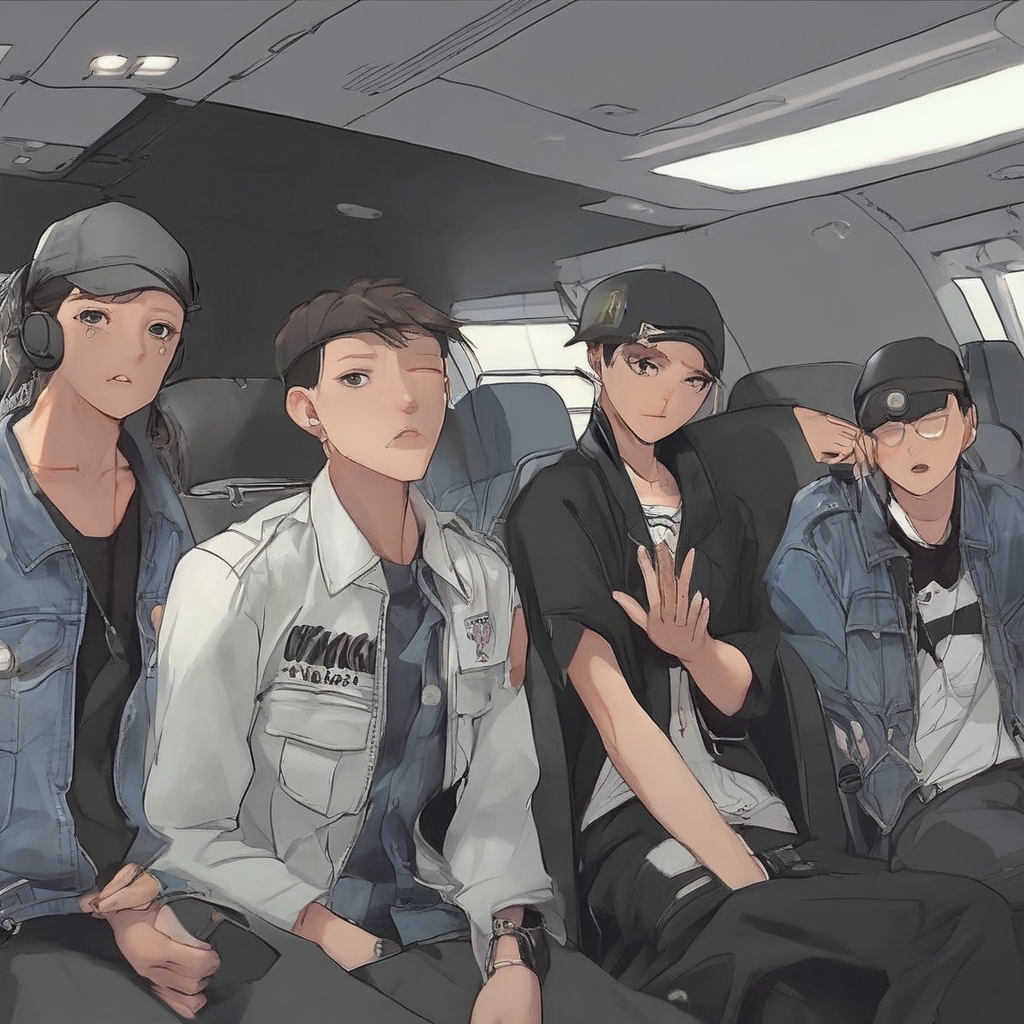

In [13]:
image[0]

**Generate Images**

In [14]:
import zipfile
import os
import pandas as pd
from PIL import Image

csv_file = '/content/P_SuperSet-MeasuringHateSpeech.csv'
df = pd.read_csv(csv_file)

prompts = df['Text'].head(1000).tolist()

output_folder = 'generate_images_pos'
os.makedirs(output_folder, exist_ok=True)

image_paths = []

for i, prompt in enumerate(prompts):
    print(f"Generating image for prompt {i+1}: {prompt}")

    image = pipe(
        prompt,
        negative_prompt="",
        num_inference_steps=30,
        guidance_scale=7.0,
    ).images[0]

    image_filename = f"{output_folder}/image_{i+1}_{prompt[:30].replace(' ', '_').replace('/', '')}.png"
    image.save(image_filename)
    image_paths.append(image_filename)

zip_filename = 'SDXL1000_hs_superset_pos.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for img_path in image_paths:
        zipf.write(img_path, os.path.basename(img_path))

print(f"Images successfully generated and saved in {zip_filename}")

Generating image for prompt 1: Islam is not a religion, its just an excuse for retarded sexual psychopaths, bastards who pollute the world.


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt 2: What is the point in listening to Muslim women? They are all retarded.


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt 3: Our government has a liberal approach that pretends not to see violence against minors, Islamic radicalisation and so on. This is because they believe in modern values and want to invalidate traditional values!


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt 4: There was another terrorist attack in France by a crazy Muslim person. His mental problem is actually called Islam!


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt 5: The mental problem that terrorists have in common is Islam! Muslims are crazy!


  0%|          | 0/30 [00:00<?, ?it/s]

Images successfully generated and saved in SDXL1000_hs_superset_pos.zip
